In [9]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import pandas as pd

# Load the graphs
with open(r'C:\\Python\\Python\\AAA_UNI\\MBD\\Project\\adw_graph_degree_none.pickle', 'rb') as f:
    G_org = pickle.load(f)
with open(r'C:\\Python\\Python\\AAA_UNI\\MBD\\Project\\adw_graph_degree_2.pickle', 'rb') as f:
    G_2 = pickle.load(f)
with open(r'C:\\Python\\Python\\AAA_UNI\\MBD\\Project\\adw_graph_degree_1.pickle', 'rb') as f:
    G_1 = pickle.load(f)

In [10]:
from sklearn.svm import OneClassSVM
import numpy as np


def svc_clustering(G: nx.Graph, num_clusters: int = 5, dimensions: int = 8, kernel: str = 'sigmoid', gamma: str = 'scale') -> list:
    pca: PCA = PCA(n_components=dimensions)
    embeddings: np.ndarray = pca.fit_transform(nx.adjacency_matrix(G).todense())
    
    oc_svm: OneClassSVM = OneClassSVM(kernel=kernel, gamma=gamma)
    oc_svm.fit(embeddings)
    
    cluster_labels: np.ndarray = oc_svm.predict(embeddings)
    
    return cluster_labels.tolist()

# Available options for kernel: 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
# Available options for gamma: 'scale', 'auto'

In [11]:
# Apply SVC clustering
num_clusters = 5
cluster_labels_org = svc_clustering(G_org, num_clusters=num_clusters)
cluster_labels_2 = svc_clustering(G_2, num_clusters=num_clusters)
cluster_labels_1 = svc_clustering(G_1, num_clusters=num_clusters)


C:\Users\tadas\AppData\Local\Temp\ipykernel_23664\2031983284.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_clusters)
c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


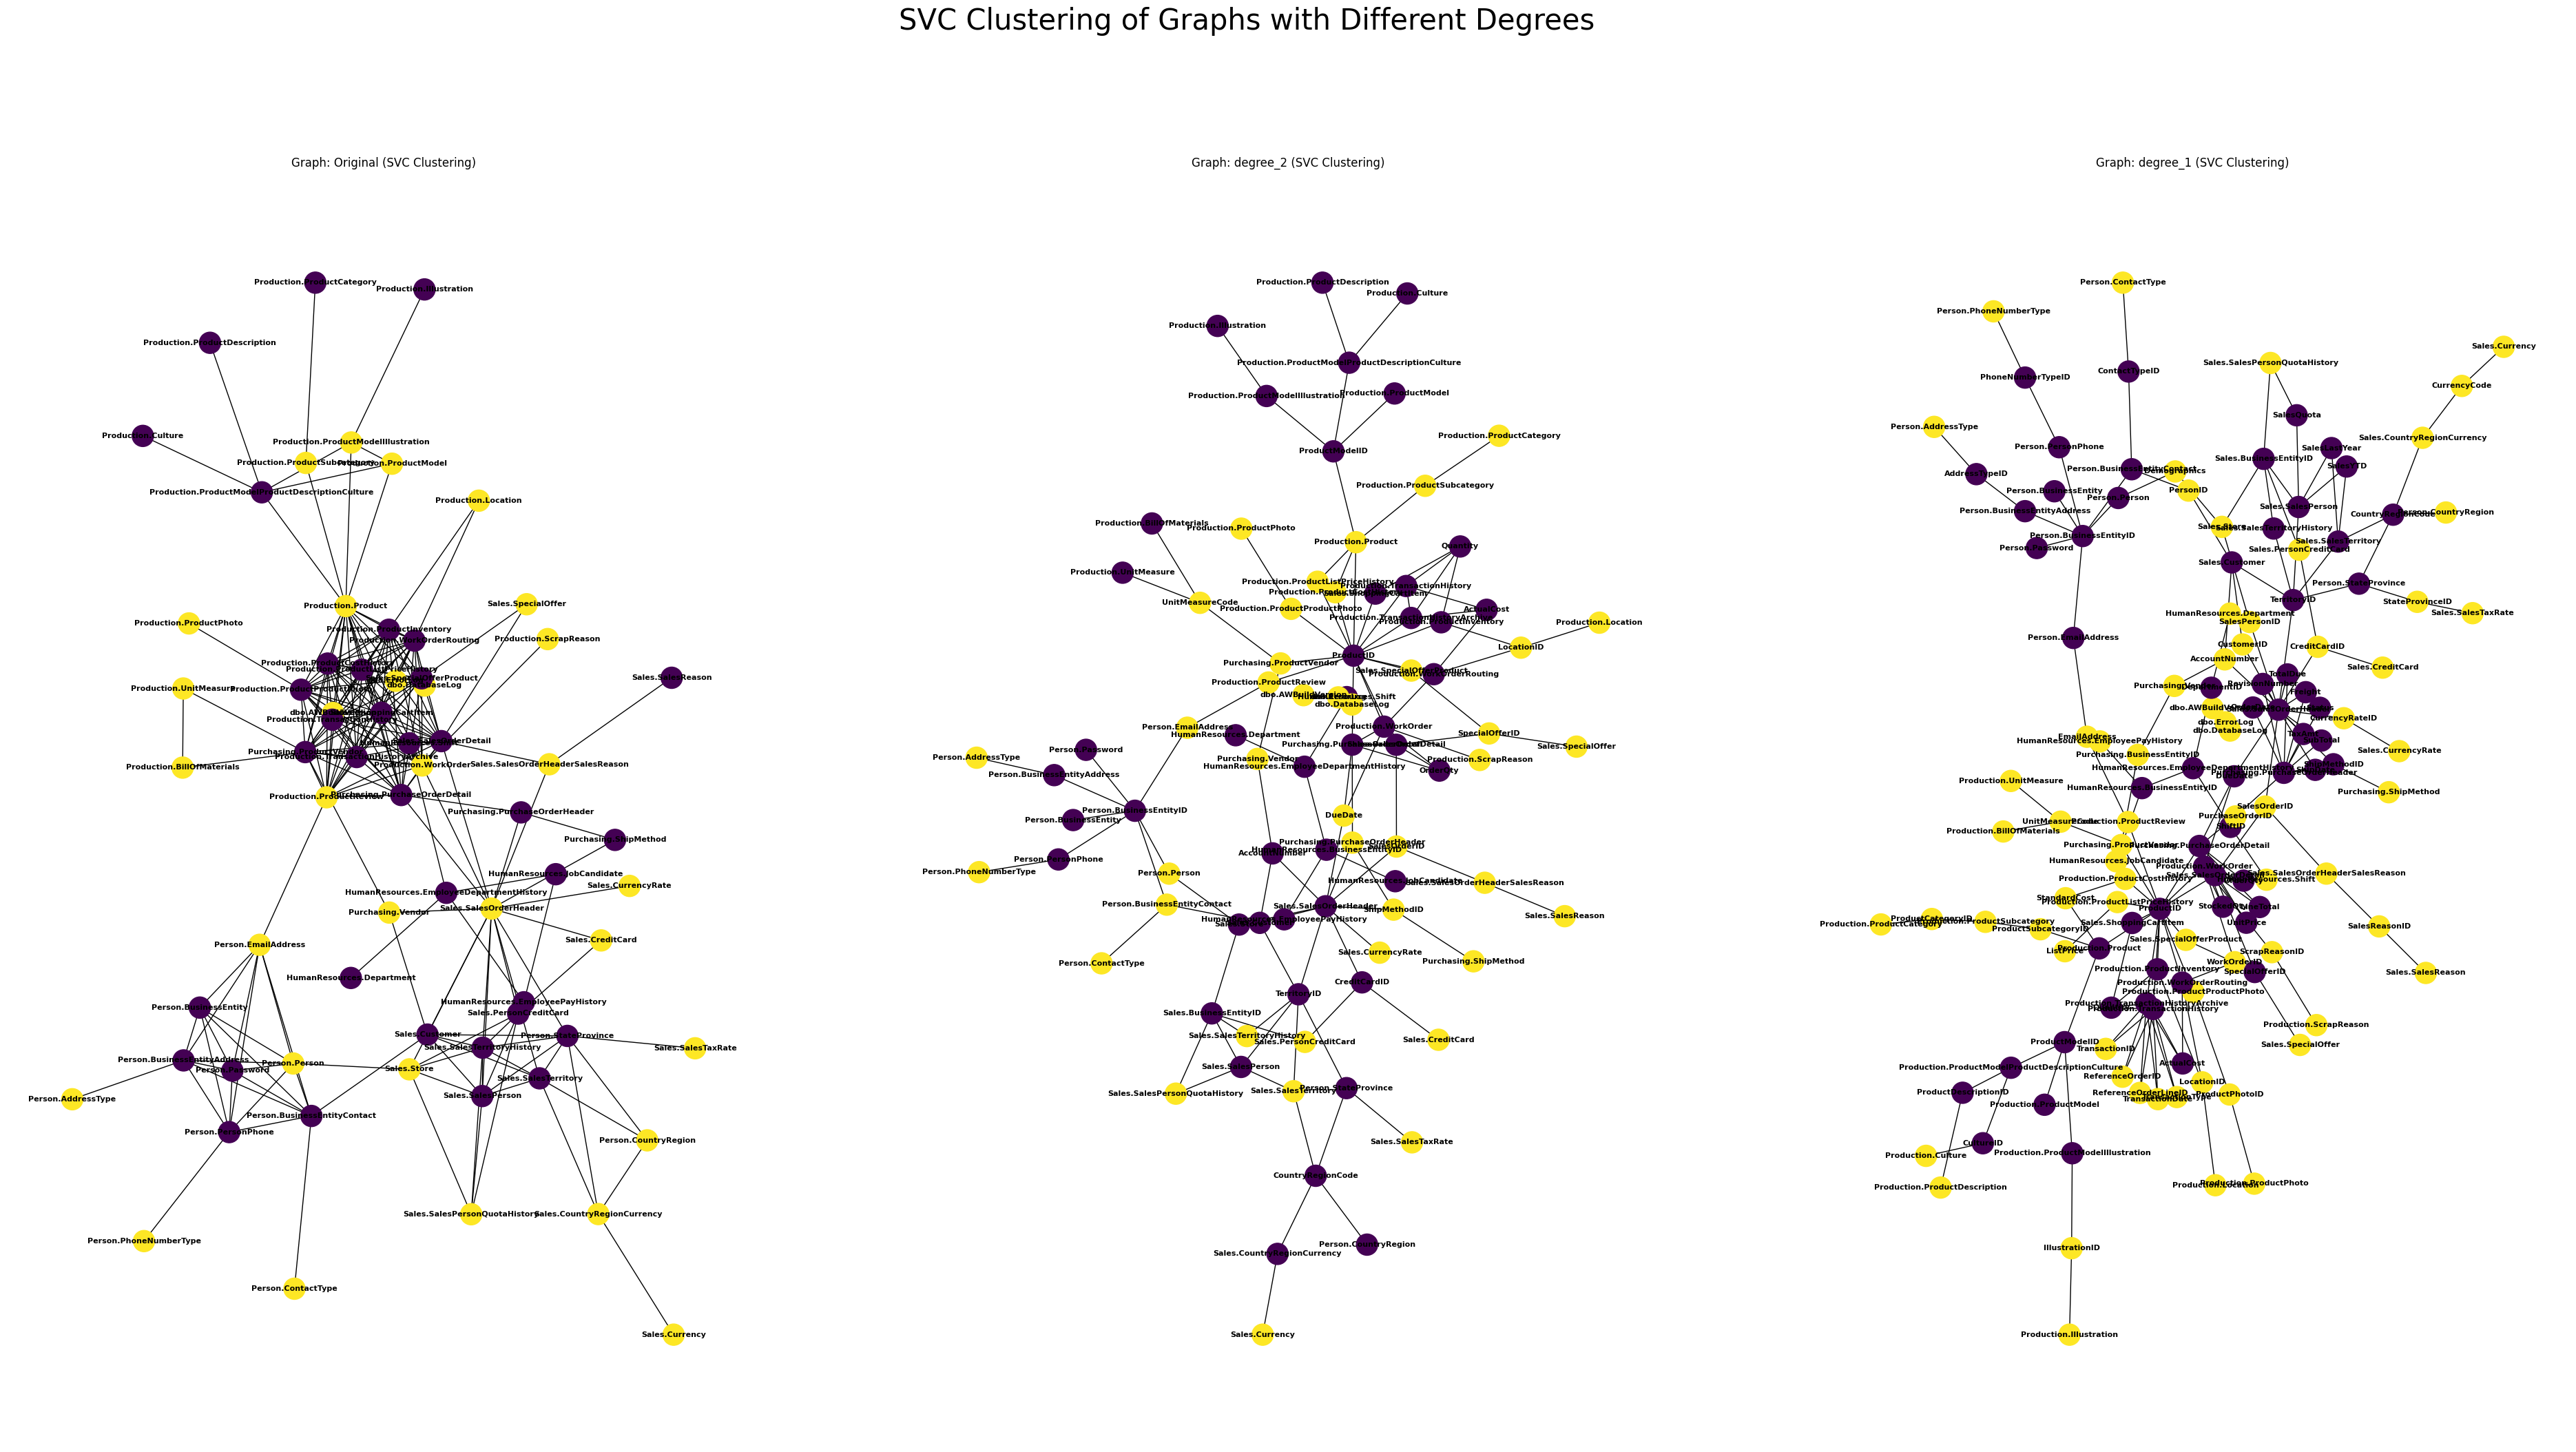

In [12]:
# Define the visualization function
def visualize_clusters(G, cluster_labels, title, ax):
    pos = nx.kamada_kawai_layout(G)
    num_clusters = len(set(cluster_labels))
    cmap = plt.cm.get_cmap('viridis', num_clusters)
    node_colors = [cmap(label) for label in cluster_labels]
    
    nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, cmap=plt.cm.viridis, node_size=500, font_size=8, font_weight='bold', ax=ax)
    ax.set_title(title)

# Visualize the clusters
fig, axs = plt.subplots(1, 3, figsize=(48, 24))

visualize_clusters(G_org, cluster_labels_org, "Graph: Original (SVC Clustering)", axs[0])
visualize_clusters(G_2, cluster_labels_2, "Graph: degree_2 (SVC Clustering)", axs[1])
visualize_clusters(G_1, cluster_labels_1, "Graph: degree_1 (SVC Clustering)", axs[2])

plt.suptitle("SVC Clustering of Graphs with Different Degrees", fontsize=30)
plt.show()

In [13]:
# Create dataframes for the clusters
def create_cluster_dataframe(G, cluster_labels):
    data = [{'cluster_label': cluster, 'node_label': node.split('.')[1] if '.' in node else node} for node, cluster in zip(G.nodes(), cluster_labels)]
    df = pd.DataFrame(data)
    return df

df_org = create_cluster_dataframe(G_org, cluster_labels_org)
df_2 = create_cluster_dataframe(G_2, cluster_labels_2)
df_1 = create_cluster_dataframe(G_1, cluster_labels_1)

In [14]:
# Load the table names DataFrame
table_names_df = pd.read_csv(r"C:\\Python\\Python\\AAA_UNI\\MBD\\Project\\gitlab\\graph_analysis\\tables_and_schemas")

# Define the similarity calculation function
def calculate_similarity(schema_df, cluster_df):
    schema_set = set(schema_df['table_name'])
    matching = sum(1 for label in cluster_df['node_label'] if label in schema_set)
    total_schema = len(schema_df)
    total_cluster = len(cluster_df)
    return matching, total_schema, total_cluster

In [15]:
# Define the function to calculate best matches
def calculate_best_matches(subgraph_node_data):
    best_matches = {}
    best_similarity = {}
    match_ratio = {}

    unique_clusters = subgraph_node_data['cluster_label'].unique()
    for cluster in unique_clusters:
        cluster_df = subgraph_node_data[subgraph_node_data['cluster_label'] == cluster]
        best_similarity[cluster] = 0.0
        best_matches[cluster] = None

        unique_schemas = table_names_df['table_schema'].unique()

        for schema in unique_schemas:
            schema_df = table_names_df[table_names_df['table_schema'] == schema]

            matching, total_schema, total_cluster = calculate_similarity(schema_df, cluster_df)

            similarity_percentage = (matching / total_cluster) * 100

            if similarity_percentage > best_similarity[cluster]:
                best_similarity[cluster] = similarity_percentage
                best_matches[cluster] = schema

            match_ratio[(cluster, schema)] = f"{total_cluster}/{matching}"
            
    overall_average_similarity = 0
    for cluster, schema in best_matches.items():
        if schema is not None:
            print(f"Best match for cluster {cluster+1} is schema '{schema}' with similarity {best_similarity[cluster]:.2f}% ({match_ratio[(cluster, schema)]})")
            overall_average_similarity += best_similarity[cluster]
    print(f'Overall Average similarity: {(overall_average_similarity/len(best_matches.items())):.2f}%')

In [16]:
# Apply the similarity calculation to each clustered graph
print("Original Graph Clustering:")
calculate_best_matches(df_org)

print("\nDegree > 2 Graph Clustering:")
calculate_best_matches(df_2)

print("\nDegree > 1 Graph Clustering:")
calculate_best_matches(df_1)

Original Graph Clustering:
Best match for cluster 2 is schema 'Production' with similarity 35.48% (31/11)
Best match for cluster 0 is schema 'Production' with similarity 33.33% (36/12)
Overall Average similarity: 34.41%

Degree > 2 Graph Clustering:
Best match for cluster 2 is schema 'Sales' with similarity 29.27% (41/12)
Best match for cluster 0 is schema 'Production' with similarity 29.55% (44/13)
Overall Average similarity: 29.41%

Degree > 1 Graph Clustering:
Best match for cluster 2 is schema 'Production' with similarity 20.29% (69/14)
Best match for cluster 0 is schema 'Production' with similarity 14.75% (61/9)
Overall Average similarity: 17.52%
